In [1]:
import pandas as pd
import os
from rnalysis import filtering
from rnalysis import enrichment
import plotly
import numpy as np
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import goenrich
import gseapy as gp
import matplotlib.pyplot as plt

In [2]:
os.getcwd()

'c:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi\\notebooks'

Load Data

In [3]:
## Load in files provided by site
tbidata=pd.read_csv('C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi\\data\\raw\\tbi_data_files.csv')
donor=pd.read_csv('C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi\\data\\raw\\DonorInformation.csv')
genes=pd.read_csv('C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi\\data\\raw\\gene_expression_matrix_2016-03-03\\rows-genes.csv')



In [4]:
# # read in files needed to be downloaded to get counts, create dataframe from these files, takes 20min

# file_links=tbidata['gene_level_fpkm_file_link'].to_list()
# for link in file_links:
#     if link==file_links[0]:
#         print("http://api.brain-map.org"+link)
#         df_gene_counts=pd.read_csv("http://api.brain-map.org"+link,delimiter='\\t')
#         df_gene_counts['link']=link
#     else:
#         file_link="http://api.brain-map.org"+link
#         new_file=pd.read_csv(file_link,delimiter='\\t')
#         new_file['link']=link
#         df_gene_counts=pd.concat([df_gene_counts,new_file])


# # df_gene_counts


In [5]:
# #save df as csv as to not repeat process
# df_gene_counts.to_csv('C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi\\data\\df_gene_counts.csv')

Merge files to transform returned API data to count matrix

In [6]:
# Read in count file previously generated and saved
df_gene_counts=pd.read_csv('C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi\\data\\interim\\df_gene_counts.csv')


In [7]:
#df_gene_counts[df_gene_counts['gene_id']==3507]

In [8]:
merge_table=df_gene_counts.merge(tbidata,left_on='link',right_on='gene_level_fpkm_file_link')

In [9]:
merge_table.columns

Index(['Unnamed: 0', 'gene_id', 'transcript_id(s)', 'length',
       'effective_length', 'expected_count', 'TPM', 'FPKM', 'link', 'donor_id',
       'donor_name', 'specimen_id', 'specimen_name', 'rna_well',
       'rna_integrity_number', 'structure_id', 'structure_acronym',
       'structure_name', 'rnaseq_profile_id', 'rnaseq_total_reads',
       'rnaseq_percent_reads_aligned_to_mrna',
       'rnaseq_percent_reads_aligned_to_ncrna',
       'rnaseq_percent_reads_aligned_to_genome_only',
       'gene_level_fpkm_file_link', 'anonymized_bam_file_link',
       'anonymized_bam_index_file_link', 'bigwig_file_link'],
      dtype='object')

In [10]:
# Create mapping to map gene id in the count files to gene id used elsewhere
mapping_dict_gene=dict(zip(genes['gene_entrez_id'],genes['gene_id']))
#mapping_dict_gene

In [11]:
#choose fields needed 
total_counts=merge_table[['expected_count','TPM','FPKM','donor_id', 'donor_name',
       'specimen_id', 'specimen_name','structure_id', 'structure_acronym', 'structure_name',
       'rnaseq_profile_id','gene_id']]
total_counts['gene_id_mapped']=total_counts['gene_id'].map(mapping_dict_gene)
#total_counts

In [12]:
total_counts[total_counts['gene_id_mapped'].isna()]

,expected_count,TPM,FPKM,donor_id,donor_name,specimen_id,specimen_name,structure_id,structure_acronym,structure_name,rnaseq_profile_id,gene_id,gene_id_mapped
33446,0.0,0.00,0.00,309335438,H14.09.001,309357595,H14.09.001.HIP.05,10294,HIP,hippocampus (hippocampal formation),496100314,3502,NaN
33451,0.0,0.00,0.00,309335438,H14.09.001,309357595,H14.09.001.HIP.05,10294,HIP,hippocampus (hippocampal formation),496100314,3507,NaN
83729,0.0,0.00,0.00,309335438,H14.09.001,309357596,H14.09.001.PCx.01,10557,FWM,white matter of forebrain,496100278,3502,NaN
83734,0.0,0.00,0.00,309335438,H14.09.001,309357596,H14.09.001.PCx.01,10557,FWM,white matter of forebrain,496100278,3507,NaN
134012,0.0,0.00,0.00,309335438,H14.09.001,309357596,H14.09.001.PCx.01,10208,PCx,parietal neocortex,496100290,3502,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18839293,0.0,0.00,0.00,467056409,H15.09.110,467179128,H15.09.110.PCx.01,10557,FWM,white matter of forebrain,496100657,3507,NaN
18889571,0.0,0.00,0.00,467056409,H15.09.110,467179128,H15.09.110.PCx.01,10208,PCx,parietal neocortex,496100653,3502,NaN
18889576,0.0,0.00,0.00,467056409,H15.09.110,467179128,H15.09.110.PCx.01,10208,PCx,parietal neocortex,496100653,3507,NaN
18939854,0.0,0.00,0.00,467056409,H15.09.110,467179131,H15.09.110.TCx.01,10235,TCx,temporal neocortex,496100646,3502,NaN


In [13]:
#create list to drop genes with no mapping
unmapped_genes=list(total_counts[total_counts['gene_id_mapped'].isna()]['gene_id'].unique())
total_counts=total_counts.drop(total_counts[total_counts['gene_id'].isin(unmapped_genes)].index)

In [14]:
#set fields to integer
total_counts['expected_count']=np.round(total_counts['expected_count']).astype(int)
total_counts['gene_id_mapped']=total_counts['gene_id_mapped'].astype(int)


In [15]:
#pivot table to correct formation
ct_matrix=total_counts[['gene_id_mapped','rnaseq_profile_id','expected_count']].pivot(index='gene_id_mapped',columns='rnaseq_profile_id', values='expected_count')
#ct_matrix

In [16]:
#drop zero reads
ct_matrix=ct_matrix[(ct_matrix != 0).any(axis=1)] #https://stackoverflow.com/questions/22649693/drop-rows-with-all-zeros-in-pandas-data-frame

In [17]:
#drop less than 10 reads
#ct_matrix=ct_matrix[ct_matrix.sum(axis=1)>10]

In [18]:
#save count matrix
ct_matrix.to_csv('C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi\\data\\interim\\ct_matrix.csv')

Create experiment design table

In [19]:
exp_design=donor.merge(tbidata,how='left',left_on='donor_id',right_on='donor_id')[['rnaseq_profile_id','act_demented']]
exp_design['act_demented']=exp_design['act_demented'].str.replace(' ','')
exp_design=exp_design.set_index('rnaseq_profile_id').loc[list(ct_matrix.columns)] #https://stackoverflow.com/questions/26202926/sorting-a-pandas-dataframe-by-the-order-of-a-list
exp_design.rename(columns={'act_demented':'condition'}).to_csv('C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi\\data\\interim\\exp_design.csv')

Run DESeq2 Differential Expression and Limma Voom Differential Expression

In [20]:
ct_matrix_filter=filtering.CountFilter('C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi\\data\\interim\\ct_matrix.csv',is_normalized=False)

In [21]:
ct_matrix_filter.differential_expression_deseq2(design_matrix='C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi\\data\\interim\\exp_design.csv',comparisons=[('condition','Dementia','NoDementia')],r_installation_folder='C:\Program Files\R\R-4.3.2',output_folder='C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi\\data\\interim')



Attaching package: 'BiocGenerics'



The following objects are masked from 'package:stats':



    IQR, mad, sd, var, xtabs



The following objects are masked from 'package:base':



    anyDuplicated, aperm, append, as.data.frame, basename, cbind,

    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,

    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,

    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,

    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,

    table, tapply, union, unique, unsplit, which.max, which.min





Attaching package: 'S4Vectors'



The following object is masked from 'package:utils':



    findMatches



The following objects are masked from 'package:base':



    expand.grid, I, unname





Attaching package: 'IRanges'



The following object is masked from 'package:grDevices':



    windows





Attaching package: 'MatrixGenerics'



The following objects are masked from 'package:matrixStats'

(DESeqFilter('C:/Users/dyeca/AppData/Local/RNAlysis/RNAlysis/Cache/2023_11_14/38f0f5fbfe8c4203d28e951bc2cad55ba08c9362/DESeq2_condition_Dementia_vs_NoDementia.csv'),)

In [22]:
deseq_res_filter=filtering.DESeqFilter('C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi\\data\\interim\\DESeq2_condition_Dementia_vs_NoDementia.csv')

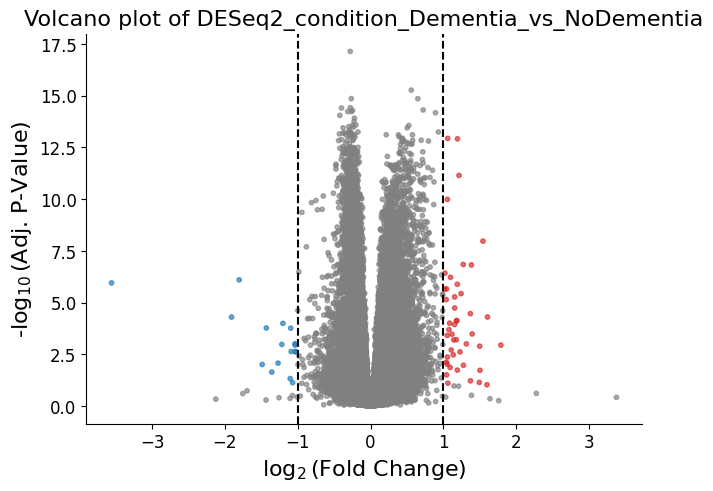

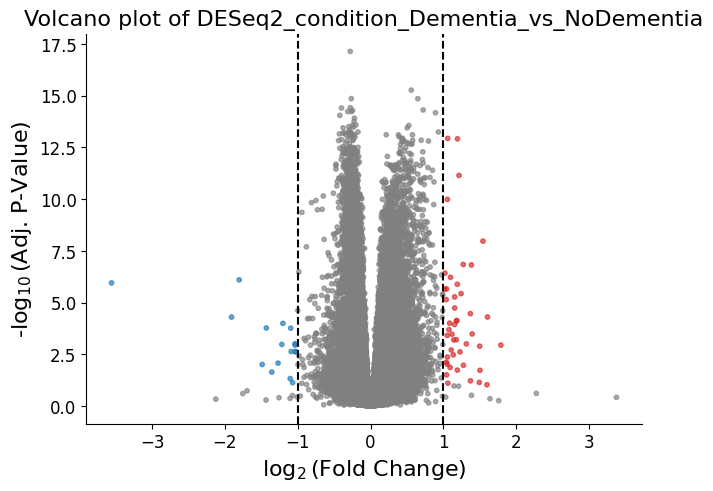

In [23]:
deseq_res_filter.volcano_plot()

In [24]:
deseq_res_filter.filter_significant(0.05)

Filtered 32300 features, leaving 14426 of the original 46726 features. Filtered inplace.


In [25]:
deseq_res_filter.head(5)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
499316280,1105.621802,-0.279198,0.028646,-9.746341,1.912362e-22,7.203104e-18
499334626,238.077979,0.560459,0.060757,9.224672,2.844300e-20,5.356670e-16
499306314,972.449482,-0.263372,0.029112,-9.046731,1.473119e-19,1.387163e-15
499329195,164.742083,0.649798,0.071800,9.050155,1.427649e-19,1.387163e-15
499326558,1897.126165,-0.277358,0.031121,-8.912278,4.999457e-19,3.766191e-15


In [26]:
#normalize to reads per million for limma voom
ct_matrix_filter.normalize_to_rpm()

Normalized 46726 features. Normalized inplace.


In [27]:
ct_matrix_filter.head(5)

,488395315,496100277,496100278,496100279,496100281,496100283,496100284,496100285,496100287,496100288,...,496100661,496100663,496100664,496100665,496100666,496100667,496100669,496100670,496100671,496100672
499304660,1.170283,0.073644,0.000000,0.000000,0.000000,0.000000,0.000000,0.231810,0.350380,0.000000,...,0.700746,0.748213,0.000000,1.022996,0.524180,0.000000,0.000000,0.314293,0.000000,0.000000
499304661,6.924174,14.287020,6.967207,6.182666,6.227801,8.510924,8.772203,6.104324,6.569633,9.531920,...,9.460069,6.869959,7.177183,8.262660,7.141947,9.609795,13.820456,11.078821,7.083001,7.959269
499304664,0.000000,0.000000,0.000000,0.228988,0.000000,0.000000,0.168696,0.154540,0.000000,0.140175,...,0.000000,0.068019,0.000000,0.078692,0.131045,0.132549,0.137517,0.000000,0.066821,0.000000
499304665,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
499304666,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.140175,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.137517,0.000000,0.000000,0.000000


In [28]:
ct_matrix_filter.differential_expression_limma_voom(design_matrix='C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi\\data\\interim\\exp_design.csv',comparisons=[('condition','Dementia','NoDementia')],r_installation_folder='C:\Program Files\R\R-4.3.2',output_folder='C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi\\data\\interim')

Loading required package: limma



(DESeqFilter('C:/Users/dyeca/AppData/Local/RNAlysis/RNAlysis/Cache/2023_11_14/299c579211ef3c74df5d6b8d5934873d517bb67d/LimmaVoom_condition_Dementia_vs_NoDementia.csv'),)

In [29]:
lv_res=pd.read_csv('C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi\\data\\interim\\LimmaVoom_condition_Dementia_vs_NoDementia.csv')
deseq2_res=pd.read_csv('C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi\\data\\interim\\DESeq2_condition_Dementia_vs_NoDementia.csv')


In [30]:
deseq2_res.head()

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,499316280,1105.621802,-0.279198,0.028646,-9.746341,1.912362e-22,7.203104e-18
1,499334626,238.077979,0.560459,0.060757,9.224672,2.844300e-20,5.356670e-16
2,499306314,972.449482,-0.263372,0.029112,-9.046731,1.473119e-19,1.387163e-15
3,499329195,164.742083,0.649798,0.071800,9.050155,1.427649e-19,1.387163e-15
4,499326558,1897.126165,-0.277358,0.031121,-8.912278,4.999457e-19,3.766191e-15


In [31]:
pval_cutoff=.05
lfc_cutoff=0.5

In [32]:
print('Significant limma voom results: {}'.format(len(lv_res[((lv_res['adj.P.Val']<pval_cutoff)&(abs(lv_res['logFC'])>lfc_cutoff))])))
print('Significant DESeq2 results: {}'.format(len(deseq2_res[(deseq2_res['padj']<pval_cutoff)&(abs(deseq2_res['log2FoldChange'])>lfc_cutoff)])))
print('Overlap significant results: {}'.format(len(set(deseq2_res[(deseq2_res['padj']<pval_cutoff)&(abs(deseq2_res['log2FoldChange'])>lfc_cutoff)]['Unnamed: 0']).intersection(set(lv_res[((lv_res['adj.P.Val']<pval_cutoff)&(abs(lv_res['logFC'])>lfc_cutoff))]['Unnamed: 0'])))))


Significant limma voom results: 209
Significant DESeq2 results: 1032
Overlap significant results: 152


Limma voom enrichment analysis

In [33]:
lv_filtered=lv_res[((lv_res['adj.P.Val']<pval_cutoff)&((abs(lv_res['logFC']))>lfc_cutoff))]

In [34]:
d_filtered=deseq2_res[((deseq2_res['padj']<pval_cutoff)&((abs(deseq2_res['log2FoldChange']))>lfc_cutoff))]

In [35]:
d_genes_merged=d_filtered.merge(genes,left_on='Unnamed: 0',right_on='gene_id')

In [36]:
lv_genes_merged=lv_filtered.merge(genes,left_on='Unnamed: 0',right_on='gene_id')

In [37]:
print(set(lv_genes_merged['gene_symbol'].astype('str')))

{'FGF17', 'IGSF9B', 'KDM6B', 'TTYH3', 'SLC4A11', 'CIC', 'GLI2', 'POLE', 'SNORD3B-1', 'LOC105372864', 'CDR1', 'BCAM', 'LOC100130238', 'SMTN', 'CICP16', 'RNF208', 'DNAH11', 'SCX', 'LAMA5', 'PPEF1', 'ANKRD20A4', 'FSCN2', 'LOC105372720', 'LOC105372722', 'LOC105376907', 'RNU11', 'LOC102723758', 'CSPG4P12', 'GAD2', 'LINGO1-AS1', 'MT1G', 'LOC100996573', 'SST', 'CRHR1', 'LOC101929898', 'LOC105371405', 'LOC100506585', 'SCRIB', 'LOC284933', 'FAM57B', 'LOC105378573', 'RAB43', 'LOC101059906', 'MMP17', 'NTN3', 'LOC105371419', 'LOC105376791', 'CLCF1', 'LOC105372724', 'SALL3', 'RPL15P3', 'LOC651714', 'RPL36A-HNRNPH2', 'LOC105373084', 'PCDHGA12', 'LOC105371383', 'ZNF703', 'KCNT1', 'SNX18P9', 'HIC1', 'MTSS1L', 'CRLF1', 'ADAM33', 'CROCC', 'MUC1', 'LOC105370091', 'NPIPB4', 'LOC105371384', 'GPER1', 'COL27A1', 'LOC105376900', 'LOC102724730', 'LOC105371924', 'LINC00930', 'LOC105378594', 'LOC101927793', 'KIF26A', 'LOC105375569', 'ADGRB1', 'PIRC76', 'LOC400002', 'ZNF469', 'LOC105371040', 'ADAMTS18', 'LOC10013

In [38]:
lv_results_enr = enrichment.FeatureSet(set(lv_genes_merged['gene_entrez_id'].astype('str')), 'LV_results')
d_results_enr = enrichment.FeatureSet(set(d_genes_merged['gene_entrez_id'].astype('str')), 'DESeq_results')



In [39]:
lv_results_enr

FeatureSet: 'LV_results'

In [40]:
lv_genes_merged

,Unnamed: 0,logFC,AveExpr,t,P.Value,adj.P.Val,B,gene_id,chromosome,gene_entrez_id,gene_symbol,gene_name
0,499329195,0.679696,3.567393,9.519351,2.181688e-19,1.019415e-14,31.807963,499329195,9,85301,COL27A1,"collagen, type XXVII, alpha 1"
1,499334295,0.579394,4.048218,9.083925,6.085013e-18,1.050535e-13,28.461820,499334295,11,283149,BCL9L,B-cell CLL/lymphoma 9-like
2,499334626,0.533165,4.134552,8.980654,1.321299e-17,1.360105e-13,27.686114,499334626,12,6539,SLC6A12,solute carrier family 6 (neurotransmitter tran...
3,499336992,0.539525,4.933453,8.759231,6.836887e-17,4.563720e-13,26.008864,499336992,12,5426,POLE,"polymerase (DNA directed), epsilon, catalytic ..."
4,499350441,0.553100,2.324766,8.457587,6.151042e-16,1.687572e-12,24.092081,499350441,20,140876,FAM65C,"family with sequence similarity 65, member C"
...,...,...,...,...,...,...,...,...,...,...,...,...
204,499342777,0.603866,2.169256,3.146445,1.784622e-03,9.328588e-03,-3.801930,499342777,16,100526830,SLX1A-SULT1A3,SLX1A-SULT1A3 readthrough (NMD candidate)
205,499342494,-0.530601,1.008210,-3.028180,2.630357e-03,1.292444e-02,-3.961069,499342494,16,101059953,NPIPA8,nuclear pore complex interacting protein famil...
206,499342503,-0.541175,0.832282,-2.982885,3.041992e-03,1.462046e-02,-4.062067,499342503,16,102723728,LOC102723728,nodal modulator 3-like
207,499307237,-0.599434,7.418963,-2.926599,3.635447e-03,1.701591e-02,-4.776559,499307237,1,26864,RNVU1-7,"RNA, variant U1 small nuclear 7"


Fetching and propagating GO annotations for organism 'Homo sapiens' (taxon ID:9606):   0%|          | 0/698769…

Found annotations for 46383 genes.
Mapping 19631 entries from 'UniProtKB_from' to 'Entrez Gene ID'...
Retrying in 3s
Retrying in 3s
Retrying in 3s
Retrying in 3s
Fetched: 500 / 18660
Fetched: 1000 / 18660
Fetched: 1500 / 18660
Fetched: 2000 / 18660
Fetched: 2500 / 18660
Fetched: 3000 / 18660
Fetched: 3500 / 18660
Fetched: 4000 / 18660
Fetched: 4500 / 18660
Fetched: 5000 / 18660
Fetched: 5500 / 18660
Fetched: 6000 / 18660
Fetched: 6500 / 18660
Fetched: 7000 / 18660
Fetched: 7500 / 18660
Fetched: 8000 / 18660
Fetched: 8500 / 18660
Fetched: 9000 / 18660
Fetched: 9500 / 18660
Fetched: 10000 / 18660
Fetched: 10500 / 18660
Fetched: 11000 / 18660
Fetched: 11500 / 18660
Fetched: 12000 / 18660
Fetched: 12500 / 18660
Fetched: 13000 / 18660
Fetched: 13500 / 18660
Fetched: 14000 / 18660
Fetched: 14500 / 18660
Fetched: 15000 / 18660
Fetched: 15500 / 18660
Fetched: 16000 / 18660
Fetched: 16500 / 18660
Fetched: 17000 / 18660
Fetched: 17500 / 18660
Fetched: 18000 / 18660
Fetched: 18500 / 18660
Fetched

Mapping 26246 entries from 'RNAcentral' to 'Entrez Gene ID'...
Mapping 26246 entries from 'RNAcentral' to 'UniProtKB_to'...
Mapping 506 entries from 'ComplexPortal' to 'Entrez Gene ID'...
Mapping 506 entries from 'ComplexPortal' to 'UniProtKB_to'...
Retrying in 3s
Fetched: 500 / 1464
Fetched: 1000 / 1464
Fetched: 1464 / 1464
Mapping 501 entries from 'UniProtKB_from' to 'Entrez Gene ID'...


When using the Copy-on-Write mode, such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy.

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Retrying in 3s
Fetched: 404 / 404
Retrying in 3s
Fetched: 25 / 25


Generating Gene Ontology Referene Table:   0%|          | [00:00<?]

18368 background genes are used.


Enrichment will be computed on the remaining 331 genes.


Calculating enrichment for 22151 GO terms using the 'elim' method:   0%|          | [00:00<?, ?it/s]

[ProgressParallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[ProgressParallel(n_jobs=-2)]: Done   3 out of   3 | elapsed:   53.5s finished


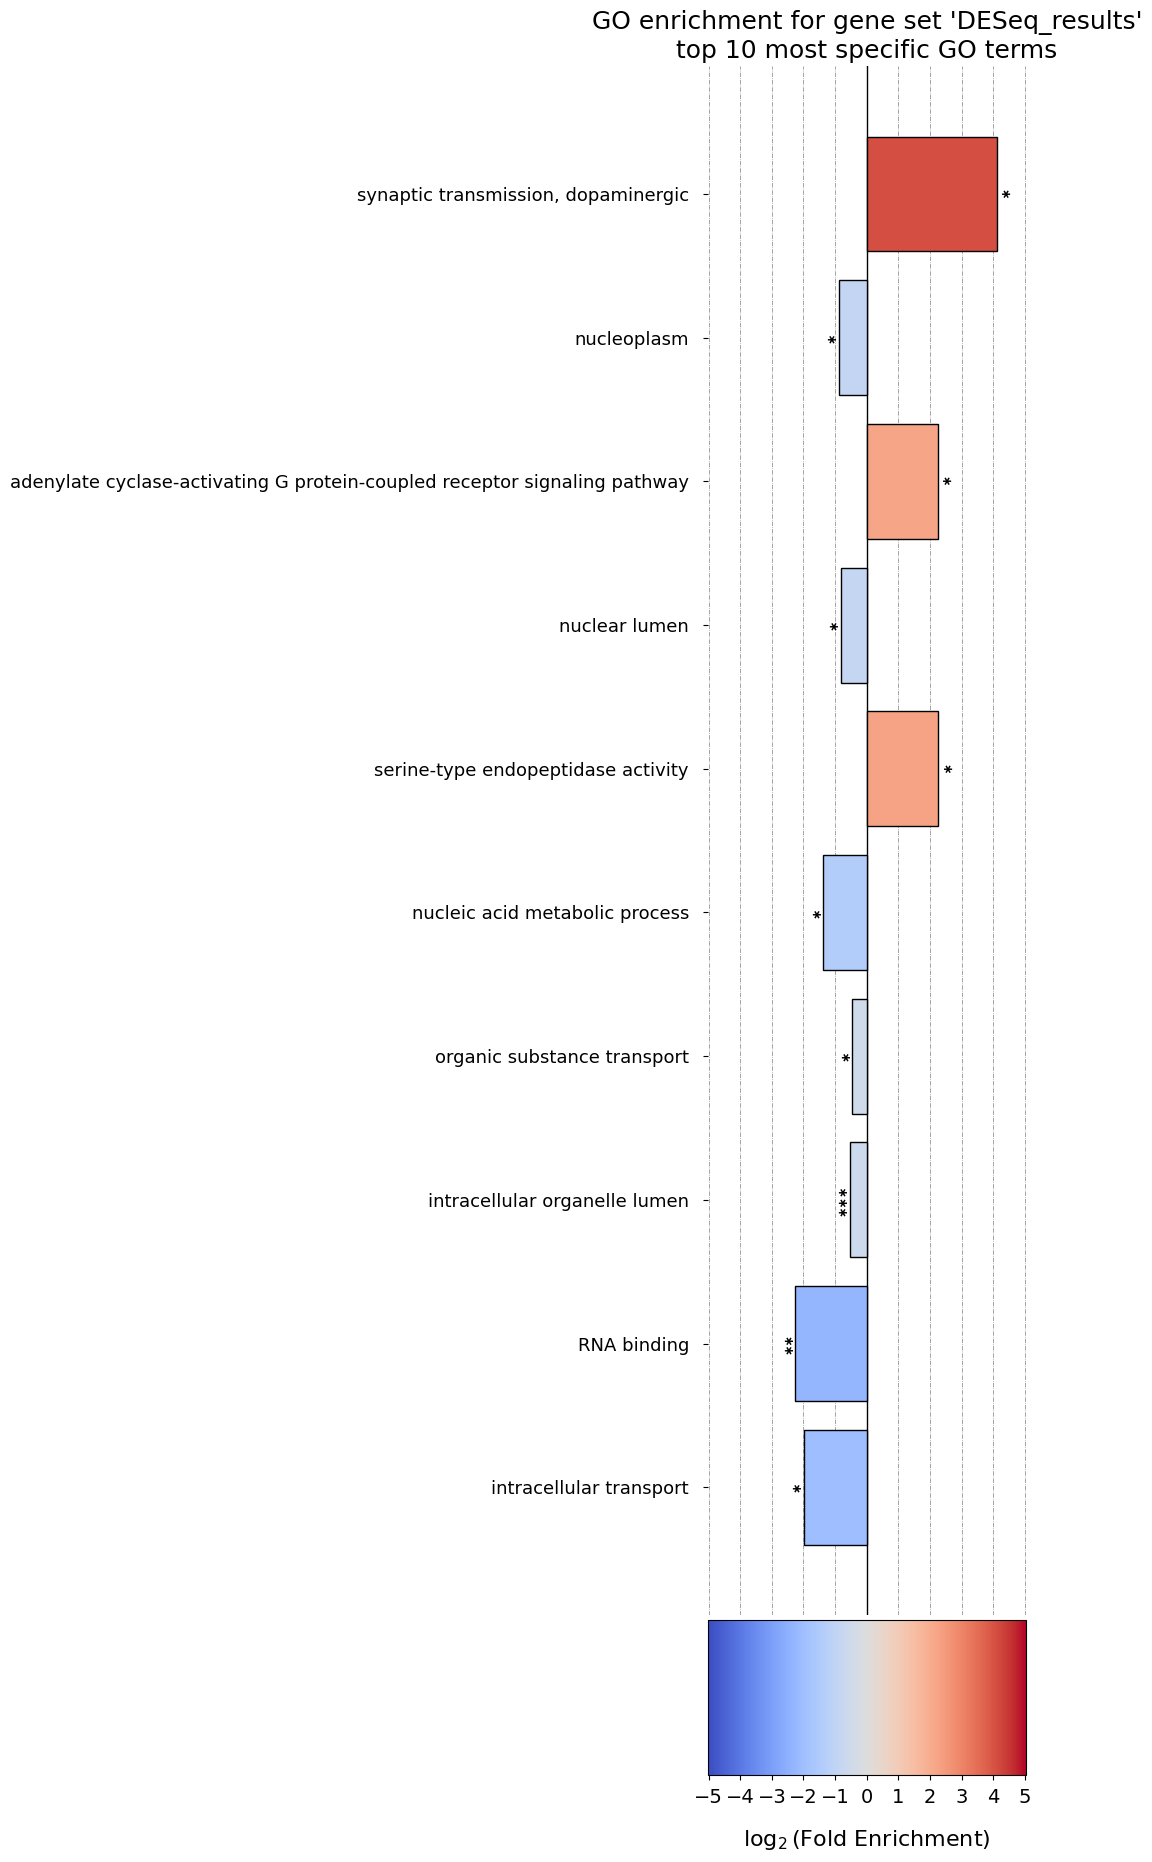


(process:20404): GLib-GIO-WARNING **: 23:07:07.110: Unexpectedly, UWP app `Microsoft.ScreenSketch_11.2309.16.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.ScreenSketch_8wekyb3d8bbwe!App') supports 29 extensions but has no verbs

(process:20404): GLib-GIO-WARNING **: 23:07:07.531: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.8.3.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

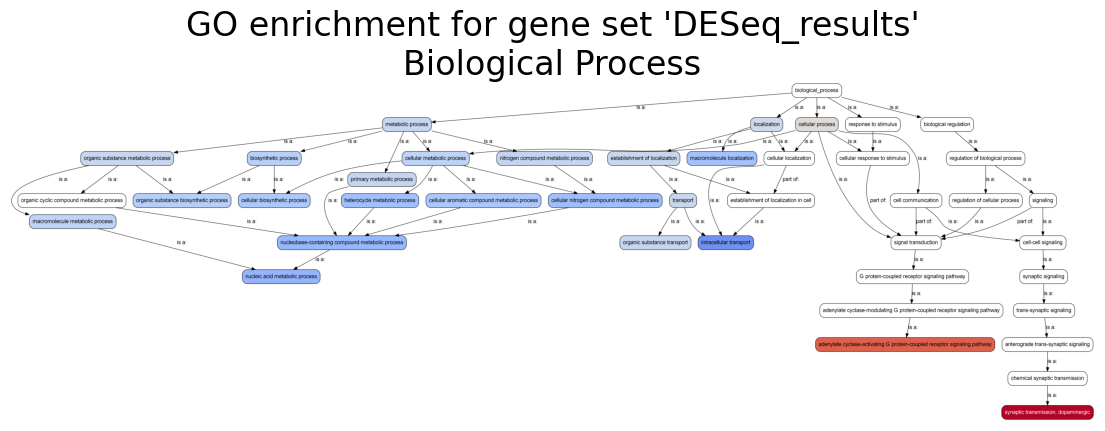

In [41]:
d_results_enr.go_enrichment(organism='9606',gene_id_type='Entrez Gene ID')


18368 background genes are used.


Enrichment will be computed on the remaining 98 genes.


Calculating enrichment for 22151 GO terms using the 'elim' method:   0%|          | [00:00<?, ?it/s]

[ProgressParallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[ProgressParallel(n_jobs=-2)]: Done   3 out of   3 | elapsed:   45.4s finished


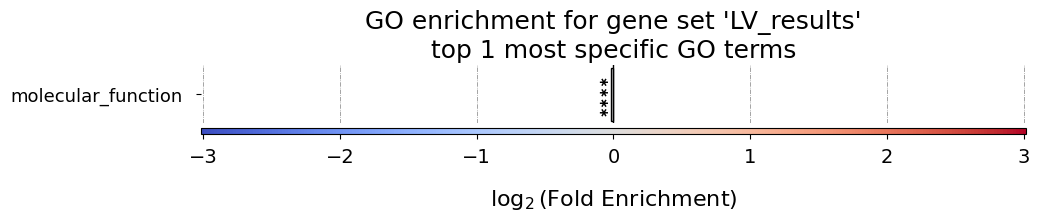

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

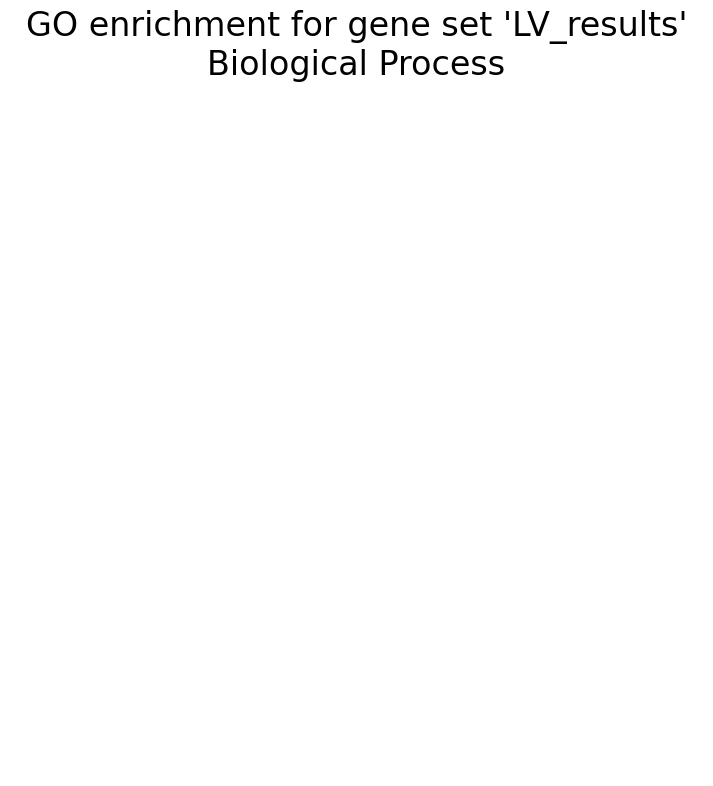

In [42]:
lv_results_enr.go_enrichment(organism='9606',gene_id_type='Entrez Gene ID')


Fetching KEGG annotations for organism 'Homo sapiens' (taxon ID:9606):   0%|          | 0/356 [00:00<?, ? anno…

Found annotations for 7085 genes.
Mapping 7085 entries from 'KEGG' to 'Entrez Gene ID'...
Mapping 7085 entries from 'KEGG' to 'UniProtKB_to'...
Fetched: 500 / 9458
Fetched: 1000 / 9458
Fetched: 1500 / 9458
Fetched: 2000 / 9458
Fetched: 2500 / 9458
Fetched: 3000 / 9458
Fetched: 3500 / 9458
Fetched: 4000 / 9458
Fetched: 4500 / 9458
Fetched: 5000 / 9458
Fetched: 5500 / 9458
Fetched: 6000 / 9458
Fetched: 6500 / 9458
Fetched: 7000 / 9458
Fetched: 7500 / 9458
Fetched: 8000 / 9458
Fetched: 8500 / 9458
Fetched: 9000 / 9458
Fetched: 9458 / 9458


When using the Copy-on-Write mode, such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy.

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Mapping 6981 entries from 'UniProtKB_from' to 'Entrez Gene ID'...
Fetched: 500 / 6995
Fetched: 1000 / 6995
Fetched: 1500 / 6995
Fetched: 2000 / 6995
Fetched: 2500 / 6995
Fetched: 3000 / 6995
Fetched: 3500 / 6995
Fetched: 4000 / 6995
Fetched: 4500 / 6995
Fetched: 5000 / 6995
Fetched: 5500 / 6995
Fetched: 6000 / 6995
Fetched: 6500 / 6995
Fetched: 6995 / 6995
Fetched: 274 / 274


Generating Gene Ontology Referene Table:   0%|          | [00:00<?]

6897 background genes are used.


Enrichment will be computed on the remaining 147 genes.


Calculating enrichment:   0%|          | [00:00<?, ?attribute/s]

[ProgressParallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[ProgressParallel(n_jobs=-2)]: Done 288 out of 288 | elapsed:   58.7s finished


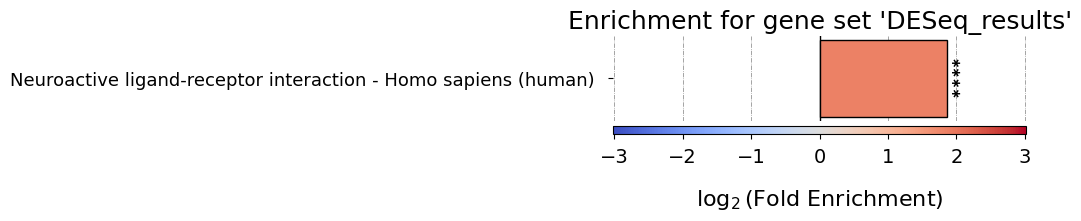

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.776414 to fit

(process:15304): GLib-GIO-WARNING **: 23:12:25.819: Unexpectedly, UWP app `Microsoft.ScreenSketch_11.2309.16.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.ScreenSketch_8wekyb3d8bbwe!App') supports 29 extensions but has no verbs

(process:15304): GLib-GIO-WARNING **: 23:12:26.185: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.8.3.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs


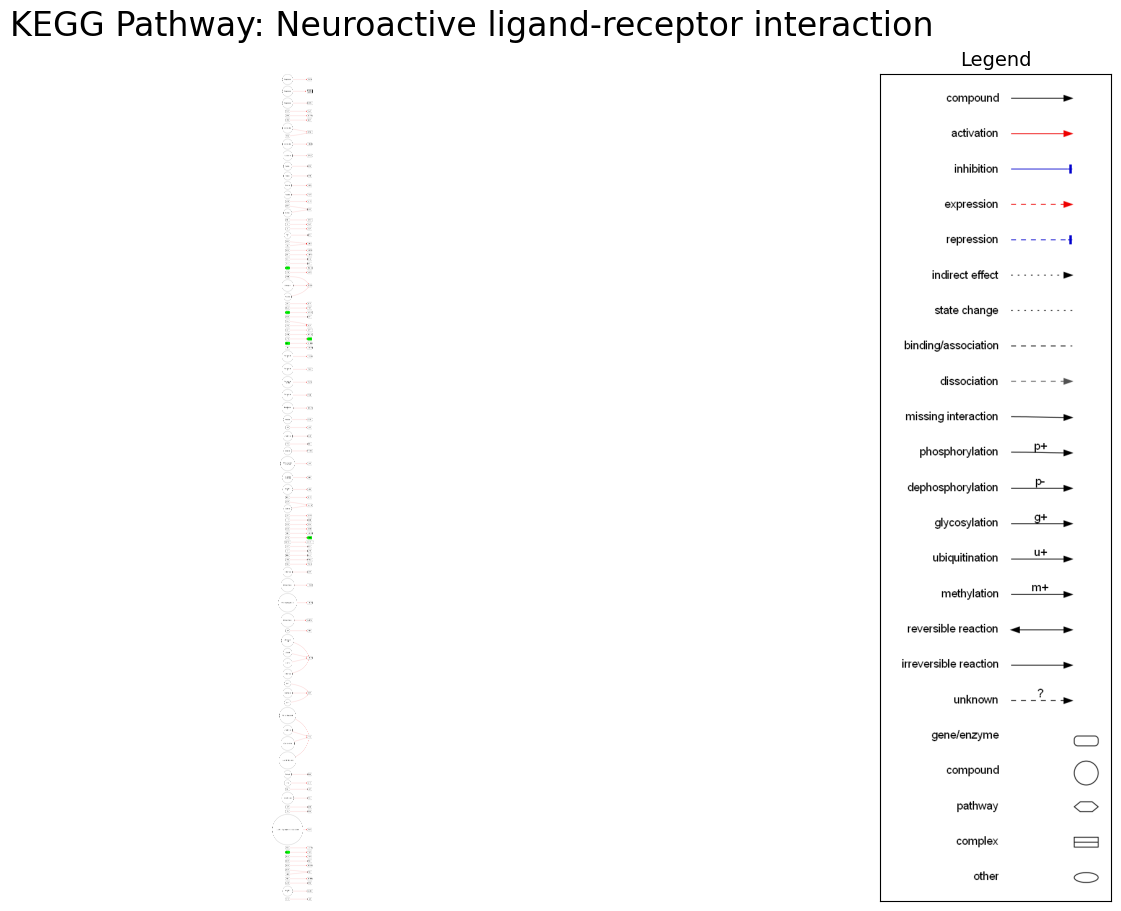

,name,samples,obs,exp,log2_fold_enrichment,pval,padj,significant
KEGG ID,,,,,,,,
hsa04080,Neuroactive ligand-receptor interaction - Homo...,147,28,7.736842,1.85561,1.811025e-09,0.000003,True


In [43]:
d_results_enr.kegg_enrichment(organism='9606',gene_id_type='Entrez Gene ID')


6897 background genes are used.


Enrichment will be computed on the remaining 37 genes.


Calculating enrichment:   0%|          | [00:00<?, ?attribute/s]

[ProgressParallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[ProgressParallel(n_jobs=-2)]: Done 288 out of 288 | elapsed:   52.0s finished


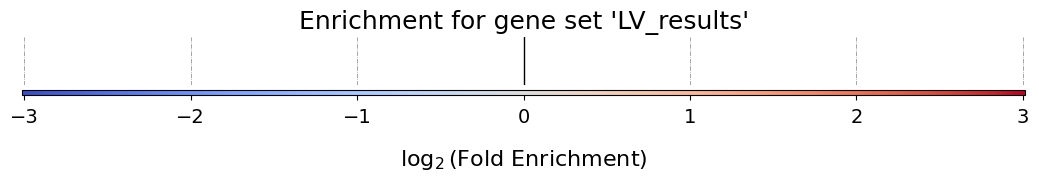

,name,samples,obs,exp,log2_fold_enrichment,pval,padj,significant
KEGG ID,,,,,,,,


In [44]:
lv_results_enr.kegg_enrichment(organism='9606',gene_id_type='Entrez Gene ID')


GO Enrichment

In [54]:
query=list(lv_genes_merged['gene_entrez_id'].astype('int'))

In [55]:
#maybe needs to be normalized?
#silhouette_clusters = ct_matrix_filter.split_kmeans(n_clusters='silhouette')


In [56]:
"""
README.md example https://pypi.org/project/goenrich/
"""

import goenrich

# build the ontology
ont = goenrich.obo.ontology('C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi//data/raw//go-basic.obo')

# use all entrez geneid associations form gene2go as background
# use goenrich.read.goa('db/gene_association.goa_human.gaf.gz') for uniprot
gene2go = goenrich.read.gene2go('C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi//data/raw//gene2go')
values = {k: set(v) for k,v in gene2go.groupby('GO_ID')['GeneID']}

# propagate the background through the ontology
background_attribute = 'gene2go'
goenrich.enrich.propagate(ont, values, background_attribute)

# extract some list of entries as example query
query = gene2go[gene2go['GeneID'].isin(query)]['GeneID'].unique()

# for additional export to graphviz just specify the gvfile argument
# the show argument keeps the graph reasonably small
df = goenrich.enrich.analyze(ont, query, background_attribute, gvfile='C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi//data//interim//example.dot')

# generate html
df.dropna().head().to_html('example.html')

# call to graphviz
import subprocess
subprocess.check_call(['dot', '-Tpng', 'C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi//data//interim//example.dot', '-o', 'C:\\Users\\dyeca\\OneDrive\\Documents\\capstone\\aging_dementia_tbi//data//interim//example.png'])

0

In [57]:
# if you are only intrested in dataframe that enrichr returned, please set outdir=None
enr = gp.enrichr(gene_list=[str(x) for x in list(list(d_genes_merged['gene_symbol']))], # or "./tests/data/gene_list.txt",
                 gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

In [58]:
enr.results


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,Allograft Rejection,17/200,0.030151,0.999973,0,0,1.719266,6.020088e+00,ITK;GZMA;GZMB;CD3E;F2;CD3D;NCR1;CD2;CD79A;CD8B...
1,MSigDB_Hallmark_2020,Complement,10/200,0.586438,0.999973,0,0,0.967041,5.160991e-01,FCN1;GZMK;CDA;CR2;TMPRSS6;LCK;GZMA;GZMB;F2;MMP8
2,MSigDB_Hallmark_2020,Pancreas Beta Cells,2/40,0.618694,0.999973,0,0,0.967297,4.644428e-01,PCSK1;SST
3,MSigDB_Hallmark_2020,Apical Surface,2/44,0.670460,0.999973,0,0,0.874988,3.498127e-01,SLC22A12;IL2RB
4,MSigDB_Hallmark_2020,Myogenesis,9/200,0.709737,0.999973,0,0,0.864888,2.965362e-01,COL1A1;SMTN;DES;CKM;SLN;COL6A2;MYH8;MYH11;AEBP1
...,...,...,...,...,...,...,...,...,...,...
256,KEGG_2021_Human,Pathways of neurodegeneration,6/475,0.999994,0.999996,0,0,0.230664,1.286766e-06,IL1A;CASP12;TUBAL3;CHRM5;FZD9;SLC6A3
257,KEGG_2021_Human,Amyotrophic lateral sclerosis,3/364,0.999995,0.999996,0,0,0.150271,7.343120e-07,POM121L2;CASP12;TUBAL3
258,KEGG_2021_Human,Herpes simplex virus 1 infection,1/498,0.999995,0.999996,0,0,0.036048,1.632841e-07,TLR9
259,KEGG_2021_Human,MicroRNAs in cancer,1/310,0.999996,0.999996,0,0,0.058569,2.313217e-07,NOTCH3


In [59]:
# if you are only intrested in dataframe that enrichr returned, please set outdir=None
enr = gp.enrichr(gene_list=[str(x) for x in list(list(lv_genes_merged['gene_symbol']))], # or "./tests/data/gene_list.txt",
                 gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

In [60]:
enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,Apical Surface,3/44,0.010875,0.239249,0,0,7.015155,31.717577,CROCC;HSPB1;ATP6V0A4
1,MSigDB_Hallmark_2020,Epithelial Mesenchymal Transition,4/200,0.157692,0.878952,0,0,1.950722,3.603206,COL5A1;COL5A3;COL6A2;CRLF1
2,MSigDB_Hallmark_2020,Pancreas Beta Cells,1/40,0.343354,0.878952,0,0,2.434911,2.602900,SST
3,MSigDB_Hallmark_2020,IL-2/STAT5 Signaling,3/199,0.345046,0.878952,0,0,1.455939,1.549231,MUC1;COL6A1;PLEC
4,MSigDB_Hallmark_2020,Estrogen Response Early,3/200,0.347899,0.878952,0,0,1.448475,1.529361,NCOR2;MUC1;CBFA2T3
...,...,...,...,...,...,...,...,...,...,...
117,KEGG_2021_Human,Endocytosis,1/252,0.930336,0.969100,0,0,0.374272,0.027026,PIP5K1C
118,KEGG_2021_Human,Prion disease,1/273,0.944291,0.970364,0,0,0.345005,0.019776,ND3
119,KEGG_2021_Human,Cytokine-cytokine receptor interaction,1/295,0.955934,0.970364,0,0,0.318828,0.014369,CLCF1
120,KEGG_2021_Human,Pathways of neurodegeneration,2/475,0.960660,0.970364,0,0,0.394603,0.015837,DNAH11;ND3


In [61]:
from gseapy import barplot, dotplot


In [63]:
# categorical scatterplot
ax = dotplot(enr.results,
              column="Adjusted P-value",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=10,
              top_term=5,
              figsize=(3,5),
              title = "KEGG",
              xticklabels_rot=45, # rotate xtick labels
              show_ring=True, # set to False to revmove outer ring
              marker='o',
             )

ValueError: Warning: No enrich terms when cutoff = 0.05

In [64]:
d_genes_merged

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_id,chromosome,gene_entrez_id,gene_symbol,gene_name
0,499334626,238.077979,0.560459,0.060757,9.224672,2.844300e-20,5.356670e-16,499334626,12,6539,SLC6A12,solute carrier family 6 (neurotransmitter tran...
1,499329195,164.742083,0.649798,0.071800,9.050155,1.427649e-19,1.387163e-15,499329195,9,85301,COL27A1,"collagen, type XXVII, alpha 1"
2,499348654,60.631167,0.723580,0.081798,8.845946,9.075617e-19,4.883460e-15,499348654,19,4059,BCAM,basal cell adhesion molecule (Lutheran blood g...
3,499315843,27.153886,0.892610,0.101888,8.760663,1.941053e-18,6.646520e-15,499315843,4,285489,DOK7,docking protein 7
4,499334295,223.946601,0.526567,0.061546,8.555698,1.171575e-17,2.751738e-14,499334295,11,283149,BCL9L,B-cell CLL/lymphoma 9-like
...,...,...,...,...,...,...,...,...,...,...,...,...
1027,499352535,0.644525,0.554380,0.235397,2.355091,1.851817e-02,4.860327e-02,499352535,22,105373088,LOC105373088,uncharacterized LOC105373088
1028,499320728,0.394571,0.617004,0.262007,2.354911,1.852712e-02,4.861321e-02,499320728,6,105374979,LOC105374979,uncharacterized LOC105374979
1029,499354975,0.446058,-0.512335,0.217855,-2.351729,1.868637e-02,4.896283e-02,499354975,Y,286568,RPL41P6,ribosomal protein L41 pseudogene 6
1030,499337119,2.220644,-0.501284,0.213276,-2.350402,1.875314e-02,4.911045e-02,499337119,13,100421313,GAPDHP52,glyceraldehyde 3 phosphate dehydrogenase pseud...


In [65]:
rnk = d_genes_merged[['gene_symbol','log2FoldChange']].set_index('gene_symbol').sort_values(by='log2FoldChange',ascending=False)
rnk.head()

,log2FoldChange
gene_symbol,
LOC100652955,1.790493
LOC105377601,1.606848
LOC105377639,1.544631
KRT16,1.503677
LOC105372951,1.499019


In [70]:
pre_res = gp.prerank(rnk=rnk, # or rnk = rnk,
                     gene_sets='KEGG_2016',
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )

                    #https://gseapy.readthedocs.io/en/latest/gseapy_example.html#How-to-generate-your-GSEA-plot-inside-python-console

2023-11-14 23:20:02,826 [WARNING] Duplicated values found in preranked stats: 0.68% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-11-14 23:20:02,842 [INFO] Parsing data files for GSEA.............................
2023-11-14 23:20:02,843 [INFO] Enrichr library gene sets already downloaded in: C:\Users\dyeca\.cache/gseapy, use local file


2023-11-14 23:20:02,860 [INFO] 0271 gene_sets have been filtered out when max_size=1000 and min_size=5
2023-11-14 23:20:02,860 [INFO] 0022 gene_sets used for further statistical testing.....
2023-11-14 23:20:02,860 [INFO] Start to run GSEA...Might take a while..................
2023-11-14 23:20:03,026 [INFO] Congratulations. GSEApy runs successfully................



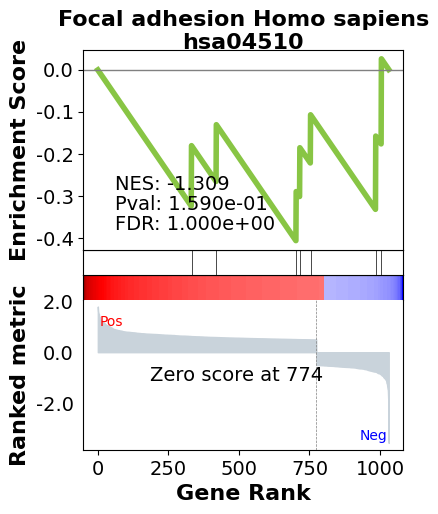

In [71]:
terms = pre_res.res2d.Term
axs = pre_res.plot(terms=terms[1])

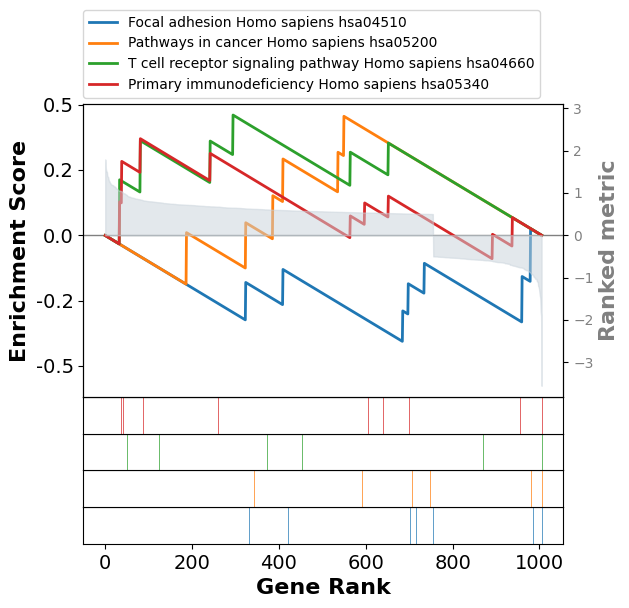

In [72]:
axs = pre_res.plot(terms=terms[1:5],
                   #legend_kws={'loc': (1.2, 0)}, # set the legend loc
                   show_ranking=True, # whether to show the second yaxis
                   figsize=(3,4)
                  )

In [73]:
from gseapy import dotplot
# to save your figure, make sure that ``ofname`` is not None
ax = dotplot(pre_res.res2d,
             column="FDR q-val",
             title='KEGG_2016',
             cmap=plt.cm.viridis,
             size=6, # adjust dot size
             figsize=(4,5), cutoff=0.25, show_ring=False)

ValueError: Warning: No enrich terms when cutoff = 0.25

In [74]:
from gseapy import enrichment_map
import networkx as nx


In [75]:
nodes, edges = enrichment_map(pre_res.res2d)


ValueError: Warning: No enrich terms when cutoff = 0.05

In [76]:
# build graph
G = nx.from_pandas_edgelist(edges,
                            source='src_idx',
                            target='targ_idx',
                            edge_attr=['jaccard_coef', 'overlap_coef', 'overlap_genes'])

NameError: name 'edges' is not defined

NameError: name 'G' is not defined

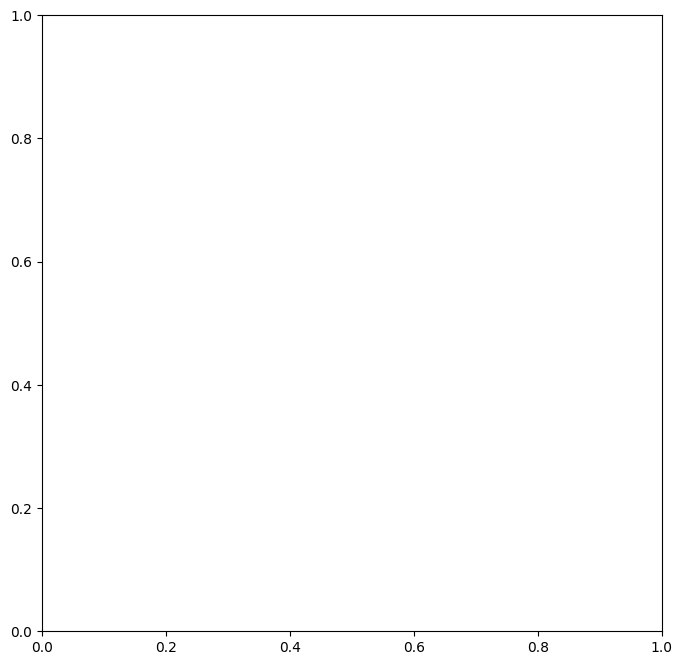

In [77]:
fig, ax = plt.subplots(figsize=(8, 8))

# init node cooridnates
pos=nx.layout.spiral_layout(G)
#node_size = nx.get_node_attributes()
# draw node
nx.draw_networkx_nodes(G,
                       pos=pos,
                       cmap=plt.cm.RdYlBu,
                       node_color=list(nodes.NES),
                       node_size=list(nodes.Hits_ratio *1000))
# draw node label
nx.draw_networkx_labels(G,
                        pos=pos,
                        labels=nodes.Term.to_dict())
# draw edge
edge_weight = nx.get_edge_attributes(G, 'jaccard_coef').values()
nx.draw_networkx_edges(G,
                       pos=pos,
                       width=list(map(lambda x: x*10, edge_weight)),
                       edge_color='#CDDBD4')
plt.show()

In [78]:

pd.concat([lv_genes_merged.sort_values(by='t').head(10),lv_genes_merged.sort_values(by='t').tail(10)])

,Unnamed: 0,logFC,AveExpr,t,P.Value,adj.P.Val,B,gene_id,chromosome,gene_entrez_id,gene_symbol,gene_name
111,499352783,-0.503142,1.459061,-6.245745,1.143282e-09,5.107170e-08,10.020228,499352783,X,5475,PPEF1,"protein phosphatase, EF-hand calcium binding d..."
142,499330118,-0.831669,1.636378,-5.699100,2.438655e-08,6.380100e-07,7.009362,499330118,10,100130992,LOC100130992,uncharacterized LOC100130992
144,499315537,-0.575087,1.380579,-5.623340,3.662741e-08,8.984001e-07,6.650474,499315537,3,6750,SST,somatostatin
164,499324505,-0.694969,1.981298,-5.113429,5.053561e-07,8.340964e-06,4.007780,499324505,7,6863,TAC1,"tachykinin, precursor 1"
170,499328366,-0.510101,0.905115,-4.929651,1.238752e-06,1.810507e-05,3.316751,499328366,9,100113421,LOC100113421,fibroblast growth factor 7 pseudogene
177,499315162,-0.537581,2.327278,-4.833050,1.963494e-06,2.684993e-05,2.641160,499315162,3,100505385,IQCJ-SCHIP1,IQCJ-SCHIP1 readthrough
183,499330167,-0.632888,3.844557,-4.676389,4.079394e-06,5.008244e-05,1.752983,499330167,10,2572,GAD2,glutamate decarboxylase 2 (pancreatic islets a...
187,499328351,-0.836168,0.281022,-4.570755,6.605488e-06,7.581296e-05,1.665331,499328351,9,728433,LOC728433,fibroblast growth factor 7 pseudogene
191,499336276,-0.712203,-0.047138,-4.427179,1.253483e-05,1.299251e-04,1.025183,499336276,12,642969,LOC642969,phosphoglycerate mutase 1 (brain) pseudogene
192,499322427,-0.701571,4.685046,-4.418093,1.304607e-05,1.345072e-04,0.571382,499322427,6,9729,KIAA0408,KIAA0408


In [79]:
pd.concat([d_genes_merged.sort_values(by='stat').head(10),d_genes_merged.sort_values(by='stat').tail(10)])

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_id,chromosome,gene_entrez_id,gene_symbol,gene_name
56,499309627,36.702591,-0.509899,0.070686,-7.213536,5.451721e-13,5.185468e-11,499309627,2,130502,TTC32,tetratricopeptide repeat domain 32
60,499352783,34.463560,-0.648376,0.090556,-7.159943,8.071090e-13,7.037168e-11,499352783,X,5475,PPEF1,"protein phosphatase, EF-hand calcium binding d..."
70,499336206,15.894155,-0.749146,0.105897,-7.074292,1.502133e-12,1.161933e-10,499336206,12,728084,LOC728084,uncharacterized LOC728084
73,499315537,36.434647,-0.810436,0.115244,-7.032352,2.030802e-12,1.471566e-10,499315537,3,6750,SST,somatostatin
80,499317260,5.094264,-0.663780,0.096167,-6.902353,5.114828e-12,3.117397e-10,499317260,4,729338,CETN4P,"centrin EF-hand protein 4, pseudogene"
83,499319747,8.586113,-0.728726,0.105711,-6.893574,5.440774e-12,3.263251e-10,499319747,5,101926975,LOC101926975,uncharacterized LOC101926975
86,499324505,69.048735,-0.942208,0.137717,-6.841638,7.829286e-12,4.355951e-10,499324505,7,6863,TAC1,"tachykinin, precursor 1"
119,499317231,41.063727,-0.508750,0.079432,-6.404810,1.505567e-10,4.952723e-09,499317231,4,4085,MAD2L1,MAD2 mitotic arrest deficient-like 1 (yeast)
134,499326780,95.176124,-0.636811,0.101149,-6.295762,3.058928e-10,8.856077e-09,499326780,8,51050,PI15,peptidase inhibitor 15
158,499335939,2.102391,-0.880580,0.143325,-6.143944,8.049698e-10,2.021333e-08,499335939,12,105369807,LOC105369807,uncharacterized LOC105369807


In [80]:
from functions import *
ct_matrix, exp_design=create_ct_matrix(gene_counts='..\\data\\interim\\df_gene_counts.csv', donor_file='..\\data\\raw\\DonorInformation.csv',tbidata_file='..\\data\\raw\\tbi_data_files.csv')
top_df=diff_exp_pipeline(ct_matrix='..\\data\\interim\\ct_matrix.csv', exp_design = '..\\data\\interim\\exp_design.csv', genes='..\\data\\raw\\gene_expression_matrix_2016-03-03\\rows-genes.csv',lv=True,pval_cutoff=.05, lfc_cutoff=0.5, r_installation_folder='C:\Program Files\R\R-4.3.2')

Normalized 46726 features. Normalized inplace.
Loading required package: limma



In [81]:
top_df

,Unnamed: 0,lfc,AveExpr,stat,P.Value,padj,B,gene_id,chromosome,gene_entrez_id,gene_symbol,gene_name
111,499352783,-0.503142,1.459061,-6.245745,1.143282e-09,5.107170e-08,10.020228,499352783,X,5475,PPEF1,"protein phosphatase, EF-hand calcium binding d..."
142,499330118,-0.831669,1.636378,-5.699100,2.438655e-08,6.380100e-07,7.009362,499330118,10,100130992,LOC100130992,uncharacterized LOC100130992
144,499315537,-0.575087,1.380579,-5.623340,3.662741e-08,8.984001e-07,6.650474,499315537,3,6750,SST,somatostatin
164,499324505,-0.694969,1.981298,-5.113429,5.053561e-07,8.340964e-06,4.007780,499324505,7,6863,TAC1,"tachykinin, precursor 1"
170,499328366,-0.510101,0.905115,-4.929651,1.238752e-06,1.810507e-05,3.316751,499328366,9,100113421,LOC100113421,fibroblast growth factor 7 pseudogene
177,499315162,-0.537581,2.327278,-4.833050,1.963494e-06,2.684993e-05,2.641160,499315162,3,100505385,IQCJ-SCHIP1,IQCJ-SCHIP1 readthrough
183,499330167,-0.632888,3.844557,-4.676389,4.079394e-06,5.008244e-05,1.752983,499330167,10,2572,GAD2,glutamate decarboxylase 2 (pancreatic islets a...
187,499328351,-0.836168,0.281022,-4.570755,6.605488e-06,7.581296e-05,1.665331,499328351,9,728433,LOC728433,fibroblast growth factor 7 pseudogene
191,499336276,-0.712203,-0.047138,-4.427179,1.253483e-05,1.299251e-04,1.025183,499336276,12,642969,LOC642969,phosphoglycerate mutase 1 (brain) pseudogene
192,499322427,-0.701571,4.685046,-4.418093,1.304607e-05,1.345072e-04,0.571382,499322427,6,9729,KIAA0408,KIAA0408
